# Data Science Job Dashboard

## Contact Information

Seth Chart, PhD

Data Scientist & Mathematician

Seeking opportunities in Data Science
 * Email: [seth.chart@protonmail.com](mailto:seth.chart@protonmail.com)
 * Phone: [443.303.7114](tel:4433037114)
 * [Resume](https://sethchart.com/resume-sethchart.pdf)
 * [GitHub](https://github.com/sethchart)
 * [LinkedIn](https://www.linkedin.com/in/sethchart)
 * [Website](https://sethchart.com)
 * [Twitter](https://www.linkedin.com/in/sethchart)

## Business Understanding

The job market for the data industry can be difficult to navigate because there are a plethora of job titles and the relationship between titles and roles is often not well defined.
Two identical roles may have completely different titles.
Two substantially different roles may have the same title.
This limits the usability of job titles as a means to succinctly communicate about data industry jobs.
This project will address the issue by directly analyzing full job descriptions from a corpus of job postings to provide three main deliverables:

### Objectives

 * First, from the language used in job descriptions (without titles), identify clusters of similar jobs based on their roles and responsibilities.
 * Second, a tool for classifying a provided job description according to our scheme.
 * Third, a comparison between our classification scheme and existing job titles ability to distinguish between roles.

### Available Resources

Recently two of the most recognizable job posting sites, LinkedIn and Indeed, have closed their job posting APIs and taken steps to discourage web scraping. This means that our preferred data sources were not available. 

We found that [careerjet.com](http://careerjet.com) has an public API and a fairly simple page structure for job posting. The official API [page](https://www.careerjet.com/partners/api/) for careerjet provides a python API package. Unfortunately, the official python package is not functional. There is an unofficial fork of the package that is functional that can be found [here](https://github.com/davebulaval/careerjet-api). 

The careerjet API is designed as a method for serving ads and tracks visits to careerjet job postings. For this reason, there are fairly restrictive rate limits for retrieving postings through the API. These limitations are not clearly documented, but they rendered the API unusable for large scale data collection.

After discovering that the careerjet API would not be usable for data collection we investigated the possibility of scraping job postings by exploiting the page number url parameter to iterate over search result pages, scrape posting results from each result listing, then scrape each result url. However, after experimentation we discovered that the site only surfaces one hundred pages of search results with twenty postings per page.

Finally, we determined that a by initiating a scraping process on the post listed first in the careerjet search results and using Selenium to advance to the next search result, we were able to access up to ten thousand job postings in a scraping session.

### Data Mining Goals

The goal of our data mining process was to obtain a reasonably large corpus of job postings consisting of a job title and a job description within the data job sector. 

### Project Plan

#### Data Collection

 1. Initiate a search for jobs postings located in the United States containing the keyword `data`. 
 2. Traverse and scrape job postings using the Selenium webdriver.
 3. Store scraped posts in a SQLite database for further analysis. 

#### Data Cleaning

The work-flow below applies to both job descriptions and job titles. This process seeks to distill the raw text to a list of unique and independent tokens of information.
 
 1. Lowercase and remove newline characters.
 2. Tokenize documents into sentences.
 3. Tokenize sentences into words.
 4. Tag words with parts-of-speech tags.
 5. Lemmatize words based on parts-of-speech tags.
 6. Remove stopwords and special characters.
 7. Group common bigrams and trigrams.

#### Modeling 

Essentially we wish to model two activities related to searching for a job. First, reading full job descriptions to determine the relevant skills and requirements, thereby classifying the job. Second, skimming over job titles to classify jobs. 

The goal of a job listing should be to efficiently communicate the requirements of the job so that employers and job seekers can easily match. Job titles are essentially a summary of the full job description which should allow a job seeker to quickly reject postings that are not relevant for further review. When the job title is not predictive of the requirements of the job, a job seeker must review full job descriptions to correctly reject job postings or accept a high false negative rate for title skimming. Either approach leads to reduced efficiency in the job seeking process. 

Our first model will produce a data supported summary of a job description, which should be as easy to parse as a job title, but more predictive of the job description.

Our second model will try to simulate the process of classifying a job by reading the job title alone. From this model, we wish to estimate the false negative rate for this method of rejecting a job posting for further review. 

##### Unsupervised Learning on Job Descriptions

Having distilled job descriptions to token lists we wish to derive meaningful representations of the job descriptions, which lend themselves to succinct classification of jobs. To this end we propose the following work-flow.
 
 1. Convert token lists to bag-of-words representation.
 2. Train a Latent Dirichlet Allocation model on the bag-of-words representations to extract a latent topics representation of the job descriptions. 
 3. Train a $k$-Means clustering model on the latent topics representations to identify clusters of similar job descriptions.
 
 The labeling of job descriptions with their corresponding cluster label provides our first deliverable.
 
 Having trained both LDA and $k$-Means models on the collected data, we can feed an unseen job description through our model pipeline and assign a cluster label. This provides our second deliverable.

##### Supervised Learning on Job Titles.

Having classified jobs to the best of our abilities using the full job description, we now wish to determine how effectively we are able to predict the cluster label of the job using only the job title. We propose the following work-flow.

 1. Convert job title token lists to token count vectors.
 2. Train a Multinomial Naive Bayes' taking job title token count vectors as inputs to predict job cluster labels. This simulates a job seeker classifying a job based on the occurrence of key words or phrases in the job title. 
 

#### Deployment


We will provide a publicly available interface, which will allow the end user to classify raw job description text.

## Imports

In [81]:
# Plotting
from matplotlib import pyplot as plt
from plotly import express as px
from wordcloud import WordCloud

def make_wordcloud(text):
    """Summary of make_wordcloud. Given a string produce a high definition 
    wordcloud of the contained words.
    """
    wordcloud = WordCloud(background_color='white', width=3200, height=2400)
    wordcloud.generate(text)
    fig = plt.figure(figsize = (16,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    return fig

# Inspecting modules
import inspect
from IPython.display import Markdown, display

def display_object(obj):
    """Summary of display_object. Get source code for the provided object 
    and display in notebook as markdown.
    """
    source = inspect.getsource(obj)
    wrapped_source = f'```python\n{source}\n```'
    markdown_source = Markdown(wrapped_source)
    display(markdown_source)
    
# Basics
import numpy as np
import pandas as pd

# Timing 
from tqdm import tqdm

# Processed data storage
import pickle

# Build corpus
from gensim import corpora

# Latent Dirichlet Allocation
from gensim.models import LdaModel

# k-means
from sklearn.cluster import KMeans

# Clustering Evaluation
from sklearn.metrics import calinski_harabasz_score, silhouette_score, confusion_matrix

# Word count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV

#Naive Bayes'
from sklearn.naive_bayes import MultinomialNB


## Data Understanding

In order to produce our deliverables, we will needed a sizable corpus of data industry job descriptions.
We were able to obtain a corpus of approximately 9,485 job descriptions paired with their assigned job titles.
The descriptions from this corpus will serve as our data for deliverables one and two.
We will use the job titles from this corpus as data for deliverable three.

### Data Collection and Storage

Data collection is executed by the `scrape` script, which depends on the `careerjet` and `JobsDb` modules. Essentially, the script bellow executes the following steps.
 1. Instantiate a `JobsDb` object, which provides methods for writing records to the database.
 2. Instantiate a `Scraper` object which opens a chrome browser and navigates to the first careerjet.com job posting page.
 3. Scrape page contents.
 4. Write record to database.
 5. Advance to next page and return to Step 3.

#### `scrape` script

In [2]:
import scrape
display_object(scrape.main)

```python
def main(number_of_pages=2):
    """Summary of main. Scrapes `number_of_pages` job postings from
    careerjet.com.

    Parameters
    ----------
    number_of_pages : int (default 2)
        number of job postings to scrape from careerjet.com.
    """
    db = JobsDb()
    scraper = Scraper()
    for page in range(number_of_pages):
        start_time = default_timer()
        sleep(rand(1))
        page_data = scraper.scrape_page()
        try:
            db.write_row_to_table('jobs', page_data)
            outcome = 'Successfully'
        except:
            outcome = 'Unsuccessfully'
        try:
            scraper.next_page()
        except:
            print('Unable to get next page.')
            pass
        elapsed = default_timer() - start_time
        print(
            f'{outcome} scraped page {page+1} of {number_of_pages} pages in {elapsed} seconds'
        )
    db.close()
    scraper.browser.close()

```

#### `careeerjet` module

In [3]:
import careerjet
display_object(careerjet)

```python
"""
This module provides the Scraper class, which encapsulates interaction with
careerjet.com through the selenium webdriver. It provides the key methods
required for executing a scrape of job postings.
"""

__author__ = "Seth Chart"
__version__ = "0.1.0"
__license__ = "MIT"

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
from time import sleep

class Scraper(object):
    """Scraper. Wraps interactions with careerjet.com through the selenium
    webdriver.
    """


    def __init__(self):
        self.browser = None
        self._initialize_scraper()

    def scrape_page(self):
        """Scrapes the current job posting"""
        soup = self._get_current_page_soup()
        page_data = {
            'title': self._get_title(soup),
            'url': self.browser.current_url,
            'description': self._get_description(soup)
        }
        return page_data

    def next_page(self):
        """Advances the browser to the next job posting"""
        nav_bar = self.browser.find_element_by_class_name('nav')
        next_button = nav_bar.find_element_by_class_name('next')
        current_url = self.browser.current_url
        next_button.click()
        wait = WebDriverWait(self.browser, 10)
        wait.until(lambda x: x.current_url != current_url)

    @staticmethod
    def _get_title(soup):
        """Extracts the job title from the current posting"""
        title = soup.find('h1').text
        return title

    @staticmethod
    def _get_description(soup):
        """Extracts the description from the current posting"""
        description = soup.find('section', class_='content').text
        return description

    def _get_current_page_soup(self):
        """Parses the current job posting using BeautifulSoup"""
        page = self.browser.page_source
        soup = BeautifulSoup(page, 'html.parser')
        return soup

    def _initialize_scraper(self):
        """Opens a new browser with the first page of creerjet search results.
        Then, clicks on the first job posting. Once this method has run, the
        scraper object is ready to scrape the first job listing.
        """
        self.browser = webdriver.Chrome()
        self.browser.get('https://www.careerjet.com/search/jobs?l=USA&s=data')
        first_job_posting = self.browser.find_element_by_class_name('job')
        first_job_link = first_job_posting.find_element_by_tag_name('a')
        first_job_link.click()

```

#### `JobsDb` module

In [4]:
import JobsDb
display_object(JobsDb)

```python
"""
This module builds a SQLite database to receive job postings from careerjet.com
and provides methods for reading from and writing to the database.
"""

__author__ = "Seth Chart"
__version__ = "0.1.0"
__license__ = "MIT"

import sqlite3
import pandas as pd

class JobsDb(object):

    def __init__(self):
        self.conn = sqlite3.connect('../data/jobs.sqlite')
        self.cur = self.conn.cursor()
        jobs_create_query = """
        CREATE TABLE IF NOT EXISTS jobs (
            id INTEGER PRIMARY KEY,
            title TEXT NOT NULL,
            url TEXT NOT NULL,
            description TEXT NOT NULL
        )
        """
        self.cur.execute(jobs_create_query)

    def close(self):
        """Closes the cursor and connection created by instantiating a JobsDb object."""
        self.cur.close()
        self.conn.close()

    def list_tables(self):
        """Queries the database and returns a list of table names."""
        query = """
            SELECT name
            FROM sqlite_master
            WHERE type='table';
        """
        response = self.cur.execute(query).fetchall()
        table_names = [r[0] for r in response]
        return table_names

    def list_column_names(self, table_name):
        """Given the name of a table in the data base, this function returns a list of column names.

        Keyword Arguments:
        table_name -- name of the table whose columns will be listed.

        Use list_tables method to obtain a list of tables.
        """
        query = f"""
            PRAGMA table_info({table_name});
            """
        response = self.cur.execute(query).fetchall()
        column_names = [r[1] for r in response]
        return column_names

    def load_query_as_df(self, query):
        """Given a valid SQL query formated as a string,
        this function returns the output of the query as
        a pandas dataframe.

        Keyword Arguments:
        query -- SQL query formated as a string.
        """
        df = pd.read_sql(query, self.conn, index_col='id')
        return df

    def load_table_as_df(self, table_name):
        """Given the name of a table in the database,
        this function loads the table as as pandas dataframe.

        Keyword Arguments:
        table_name -- name of tables whoes contents will be returned as a dataframe

        Use the list_tables method to obtain a list of tables.
        """
        query = f"""
            SELECT *
            FROM {table_name};
            """
        df = self.load_query_as_df(query)
        return df 

    def write_row_to_table(self, table_name, row_dict):
        """Given a table name and a dictionary with keys matching table column names
        and values complying with column datatypes, this function writes a new row
        to the specified table.

        Keyword Arguments:
        table_name -- name of the table to write to.
        row_dict -- dictionary containing row data.

        Use the list_tables method to obtain a list of tables.
        """
        query = f"""
            INSERT INTO {table_name} ({', '.join(row_dict.keys())})
            VALUES {tuple(row_dict.values())}
        """
        self.cur.execute(query)
        self.conn.commit()

```

### Data Description


We executed two runs of the `scrape` script. The first run did not include `data` as a search term, so it retrieved a sampling of the full job market. The second run included the search term `data`, so it retrieved a sampling of the data industry job market.

#### Load Full Dataset

In the cell below we leverage the JobsDb module to load our full data set from the database.

In [5]:
db = JobsDb.JobsDb()
df = db.load_table_as_df('jobs')
db.close()
df.head()

title  \
id                                                    
1          Psychiatrist (Per Diem) - #201222-4667HD   
2    Professor of Osteopathic Manipulative Medicine   
3   Amazon Warehouse Assistant - Immediately Hiring   
4                                Non-QM Underwriter   
5               project manager, accounting systems   

                                                  url  \
id                                                      
1   https://www.careerjet.com/jobad/us61b2e1c18a4d...   
2   https://www.careerjet.com/jobad/us0f769e5a939c...   
3   https://www.careerjet.com/jobad/usba95a3670331...   
4   https://www.careerjet.com/jobad/usb59eda9438ed...   
5   https://www.careerjet.com/jobad/us71cfd31d23d6...   

                                          description  
id                                                     
1   \n  \n    shall strive to be a global leader i...  
2   \nPosition Details  Position Title Professor o...  
3   \n  \n    Hourly pay rate: $15.00 *The base pa...  
4   \nJob Description  We looking to add an experi...  
5   \njob description  job summary:  Project Manag...

#### Total Records

In [6]:
display(Markdown(f' Our database currenlty contains {len(df)} job postings scraped from careerjet.com.'))

 Our database currenlty contains 19166 job postings scraped from careerjet.com.

#### Records Containing `data` Keyword

In [7]:
query = """
SELECT * from jobs
WHERE title LIKE '%data%'
OR description LIKE '%data%';
"""
db = JobsDb.JobsDb()
data = db.load_query_as_df(query)
db.close()
data.head()

title  \
id                              
21  Chief Development Officer   
29                QA Engineer   
30                QA Engineer   
32    Mortgage Loan Processor   
35      Survey CAD Technician   

                                                  url  \
id                                                      
21  https://www.careerjet.com/jobad/usd996fd814b15...   
29  https://www.careerjet.com/jobad/usd99666605afa...   
30  https://www.careerjet.com/jobad/usc42e0288fc11...   
32  https://www.careerjet.com/jobad/us0d171f0514c1...   
35  https://www.careerjet.com/jobad/usa5af662be4db...   

                                          description  
id                                                     
21  \nCompany Description  LaunchCode is a non-pro...  
29  \n  \n    We’d love to hear from you if you ar...  
30  \n  \n    We’d love to hear from you if you ar...  
32  \nJob Description  Be a part of a tight-knit, ...  
35  \nJob Description  Our firm is seeking a caree...

In [8]:
display(Markdown(f' Our database currenlty contains {len(data)} job postings scraped from careerjet.com with the keyword `data`.'))

 Our database currenlty contains 9666 job postings scraped from careerjet.com with the keyword `data`.

### Data Exploration

Below we explore the distribution of lengths, measured by the number of characters for job titles and job descriptions.

#### Job Titles

In [9]:
title_length = data['title'].apply(len)
median_title_length =title_length.median()
fig = px.histogram(
    title_length,
    title = f'Distribution of Job Title Lengths (Medain {median_title_length})',
    labels = {
        'value': 'Title Length (characters)',
    },
    nbins = 45,
)
fig.layout.update(showlegend=False)
fig.show()

#### Job Descriptions

In [10]:
description_length = data['description'].apply(len)
median_description_length = description_length.median()
fig = px.histogram(
    description_length,
    title = f'Distribution of Job Description Lengths (Medain {median_description_length})',
    labels = {
        'value': 'Description Length (characters)',
    },
    nbins = 45,
)
fig.layout.update(showlegend=False)
fig.show()

### Data Validation

Below we check data types and ensure that there are no missing values.

#### Data Types

All three columns from our dataset are formatted as strings. 

In [11]:
data.dtypes

title          object
url            object
description    object
dtype: object

#### Missing Values

There are no missing values in this dataset.

In [12]:
data.isna().sum()

title          0
url            0
description    0
dtype: int64

## Data Preparation

In this section we take an in depth look at the data preparation process. All data processing is handled by the `DataProcessor` module.

In [13]:
import DataProcessor
display_object(DataProcessor)

```python
"""
This module provides the full data cleaning pipeline.
"""

__author__ = "Seth Chart"
__version__ = "0.1.0"
__license__ = "MIT"

import numpy as np
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim import corpora, models

lemmatizer = WordNetLemmatizer()

def doc_tokenizer(doc):
    """doc_tokenizer. Reads in a raw text document and returns a list of
    sentences each represented as a list of words. Text is converted to
    lower_case and newline characters are removed.

    Parameters
    ----------
    doc : str
       A raw string document. 
    """
    doc = doc.replace('\\n','').lower()
    sentences = sent_tokenize(doc)
    doc_tokens = [word_tokenize(sentence) for sentence in sentences]
    return doc_tokens

def get_wordnet_pos(treebank_tag):
    """get_wordnet_pos. Converts a treebank POS tag to a wordnet POS tag.

    Parameters
    ----------
    treebank_tag : (str, str)
        First position is the token, second position is the treebank POS tag.
    """
    if treebank_tag.startswith('J'):
        tag = wordnet.ADJ
    elif treebank_tag.startswith('V'):
        tag = wordnet.VERB
    elif treebank_tag.startswith('N'):
        tag = wordnet.NOUN
    elif treebank_tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''
    return tag

def sentence_pos_tagger(sentence):
    """sentence_pos_tagger. Takes a sentence as a list of tokens and returns a
    list of wordnet POS tagged tokens.

    Parameters
    ----------
    sentence : list of strings
        list of word tokens that form a sentence.
    """
    treebank_tags = pos_tag(sentence)
    wordnet_tags = [
        (treebank_tag[0], get_wordnet_pos(treebank_tag[1])) for treebank_tag in treebank_tags
    ]
    return wordnet_tags

def doc_pos_tagger(doc_tokens):
    """doc_pos_tagger. Takes a tokenized document and returns POS tagged
    tokens.

    Parameters
    ----------
    doc_tokens : list of list of strings
        doc_tokens should be the output of doc_tokenizer.
    """
    pos_tags = [
        sentence_pos_tagger(sentence) for sentence in doc_tokens
    ]
    return pos_tags

def tag_lemmatizer(pos_tag):
    """tag_lemmatizer. Takes a POS tagged word and returns its Lemma.

    Parameters
    ----------
    pos_tag : (str, str)
        First position is a word token, second position is a wordnet POS tag.
    """
    if pos_tag[1] != '':
        lemmatized_word = lemmatizer.lemmatize(pos_tag[0], pos_tag[1])
    else:
        lemmatized_word = pos_tag[0]
    return lemmatized_word

def sentence_lemmatizer(sentence_tags):
    """sentence_lemmatizer. Takes a POS tagged sentence and lemmatizes.

    Parameters
    ----------
    sentence_tags : list of tuples (str, str)
        List of POS tagged tokens that form a sentence.
    """
    lemmatized_sentence = [
        tag_lemmatizer(pos_tag) for pos_tag in sentence_tags
    ]
    return lemmatized_sentence

def doc_lemmatizer(doc_tags):
    """doc_lemmatizer. Lemmatize tagged words from a job doc and flatten sentence nesting.

    Parameters
    ----------
    doc_tags : list of list of tuples (str, str)
        Takes output from doc_pos_tagger.
    """
    lemmatized_doc = []
    for sentence_tags in doc_tags:
        lemmatized_sentence = sentence_lemmatizer(sentence_tags) 
        lemmatized_doc.extend(lemmatized_sentence)
    return lemmatized_doc    

def doc_clean(lemmatized_doc):
    """doc_clean. Takes a lemmatized document, drops special characters and
    stopwords.

    Parameters
    ----------
    lemmatized_doc : list of strings
        Takes output from doc_lemmatizer.
    """
    my_stopwords = stopwords.words('english')
    processed_doc = [
        word for word in lemmatized_doc
        if word.isalpha() and word not in my_stopwords
        and len(word)>1
    ]
    return processed_doc

def doc_processor(doc):
    """doc_processor. Executes full data processing pipeline on a document with
    the exception of bigram and trigram grouping.

    Parameters
    ----------
    doc : str
        string containing the full text of your document.
    """
    doc_tokens = doc_tokenizer(doc)
    doc_tags = doc_pos_tagger(doc_tokens)
    lemmatized_doc = doc_lemmatizer(doc_tags)
    processed_doc = doc_clean(lemmatized_doc)
    return processed_doc

def data_processor(docs):
    """data_processor. Takes a list of raw documents and executes full data
    processing pipeline for every document in the list.

    Parameters
    ----------
    docs : list of str
        List of strings containing the full text of your documents.
    """
    processed_data = [
        doc_processor(doc) for doc in docs
    ]
    return processed_data

def data_combine_phrases(processed_data, prefix):
    """data_combine_phrases. Takes a corpus of cleaned documents and combines common phrases into
    bigrams, trigrams, and quadgrams.

    Parameters
    ----------
    processed_data : list of strings
        Takes output from data_processor.
    prefix : string
        prefix to identify saved model.
    """
    phrase_model_1 = Phrases(processed_data)
    phrase_model_1.save(f'../model/{prefix}-phrase_model_1.pkl')
    phrase_model_2 = Phrases(phrase_model_1[processed_data], min_count=1)
    phrase_model_2.save(f'../model/{prefix}-phrase_model_2.pkl')
    data_phrases = list(phrase_model_2[phrase_model_1[processed_data]])
    return data_phrases

def doc_combine_phrases(processed_doc, prefix):
    """doc_combine_phrases. Takes a processed document and combines common
    phrases into bigrams, trigrams, and quadgrams. data_combine_phrases must
    run before doc_combine_phrases.

    Parameters
    ----------
    processed_doc : list of strings
        Takes output from doc_processor.
    prefix : string
        prefix to identify saved model.
    """
    try:
        phrase_model_1 = Phrases.load(f'../model/{prefix}-phrase_model_1.pkl')
        phrase_model_2 = Phrases.load(f'../model/{prefix}-phrase_model_2.pkl')
    except:
        print('Call `data_combine_phrases` on processed data to build a phrase model')
        pass
    doc_phrases = list(phrase_model_2[phrase_model_2[processed_doc]])
    return doc_phrases


```

### Data Selection

For the purposed of this analysis we are only interested in job postings related to the data industry. For this reason we will only include postings the contain the keyword `data ` in either the job title or the job description. We have already extracted this data from the database [here](#Records-Containing-data-Keyword). For your convenience we reproduce the required code below.
```python
query = """
SELECT * from jobs
WHERE title LIKE '%data%'
OR description LIKE '%data%';
"""
db = JobsDb.JobsDb()
data = db.load_query_as_df(query)
db.close()
```

### Data Cleaning

To quickly demonstrate the steps in our data cleaning pipeline, we will select a single example record and apply each step in sequence.

#### Selecting an Example Job Post

Below we select a job posting at random from the data.

In [14]:
example_index = np.random.choice(len(data))
job_post = data.iloc[example_index]
title = job_post['title']
description = job_post['description']
print(f'{title}\n\n{description}')

Customer Service Representative Full-time & Part-time (Data Entry Clerk)

\n  \n    Customer Service Representative Full-time & Part-time (Data Entry Clerk) ** Customer Service & Sales, Customer Service, Administrative Assistant or Marketing Jobs Near Me  We are looking for people nationwide interested in working from home who are dependable and looking to make $800-$2,000 weekly . You work when you want right from your computer doing online work in the market research sector. It's fun and it pays great!  We are Accepting Applicants Regardless of Past or Current Experience and Employment Status. With or without past experience, we will train you.  Are you ready to become one of the 3.3 million people in the U.S who work form home and help fill the increasing demand for dependable telecommuting workers? If you are able to self-manage, stay focused and work independently, then you may be the IDEAL Candidate.  Our top earners come from various backgrounds such as Customer Service, Sales, 

##### Raw description word cloud

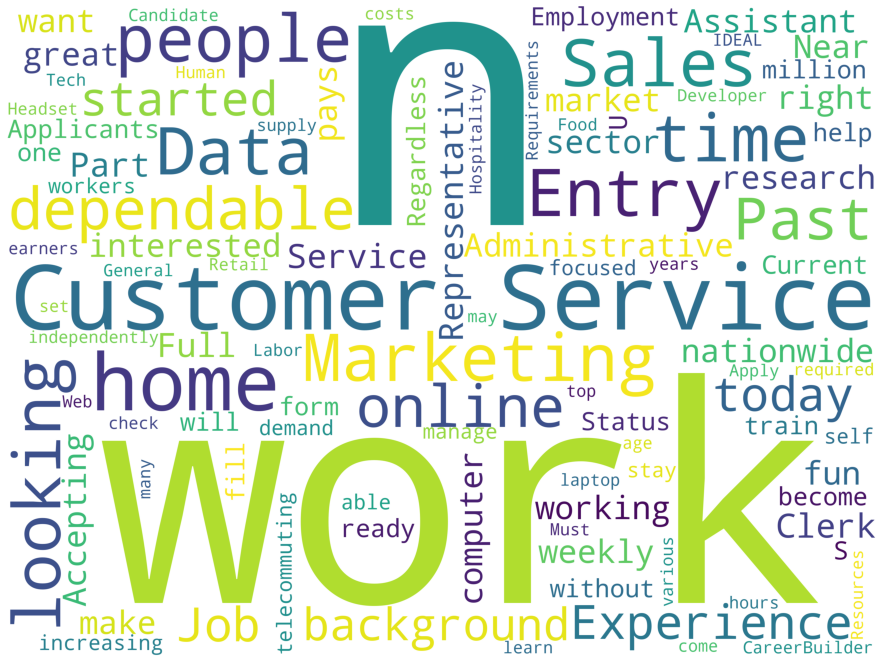

In [15]:
fig = make_wordcloud(description)

#### Tokenizing Text

The `doc_tokenizer` method first splits a document into a list of sentences, then splits each sentence into a list of words. This method depends on the following methods:
 * `sent_tokenize` and `word_tokenize` from `nltk.tokenize`.

##### `doc_tokenizer` method

In [16]:
display_object(DataProcessor.doc_tokenizer)

```python
def doc_tokenizer(doc):
    """doc_tokenizer. Reads in a raw text document and returns a list of
    sentences each represented as a list of words. Text is converted to
    lower_case and newline characters are removed.

    Parameters
    ----------
    doc : str
       A raw string document. 
    """
    doc = doc.replace('\\n','').lower()
    sentences = sent_tokenize(doc)
    doc_tokens = [word_tokenize(sentence) for sentence in sentences]
    return doc_tokens

```

##### Example output

In [17]:
title_tokens = DataProcessor.doc_tokenizer(title)
description_tokens = DataProcessor.doc_tokenizer(description)
print(f'{title_tokens}\n\n{description_tokens}')

[['customer', 'service', 'representative', 'full-time', '&', 'part-time', '(', 'data', 'entry', 'clerk', ')']]

[['customer', 'service', 'representative', 'full-time', '&', 'part-time', '(', 'data', 'entry', 'clerk', ')', '*', '*', 'customer', 'service', '&', 'sales', ',', 'customer', 'service', ',', 'administrative', 'assistant', 'or', 'marketing', 'jobs', 'near', 'me', 'we', 'are', 'looking', 'for', 'people', 'nationwide', 'interested', 'in', 'working', 'from', 'home', 'who', 'are', 'dependable', 'and', 'looking', 'to', 'make', '$', '800-', '$', '2,000', 'weekly', '.'], ['you', 'work', 'when', 'you', 'want', 'right', 'from', 'your', 'computer', 'doing', 'online', 'work', 'in', 'the', 'market', 'research', 'sector', '.'], ['it', "'s", 'fun', 'and', 'it', 'pays', 'great', '!'], ['we', 'are', 'accepting', 'applicants', 'regardless', 'of', 'past', 'or', 'current', 'experience', 'and', 'employment', 'status', '.'], ['with', 'or', 'without', 'past', 'experience', ',', 'we', 'will', 'train'

#### Parts of Speech Tagging

The `doc_pos_tagger` method parses the tokenized text from the step above and applies a wordnet part of speech tag. This method depends on the following methods:
 * `sentence_pos_tagger` and `get_wordnet_pos` from `DataProcessor`
 * `pos_tag` from `nltk`
 * `wordnet` from `nltk.corpus`

##### `doc_pos_tagger` method

In [18]:
display_object(DataProcessor.doc_pos_tagger)

```python
def doc_pos_tagger(doc_tokens):
    """doc_pos_tagger. Takes a tokenized document and returns POS tagged
    tokens.

    Parameters
    ----------
    doc_tokens : list of list of strings
        doc_tokens should be the output of doc_tokenizer.
    """
    pos_tags = [
        sentence_pos_tagger(sentence) for sentence in doc_tokens
    ]
    return pos_tags

```

##### Example output

In [19]:
title_pos_tags = DataProcessor.doc_pos_tagger(title_tokens)
description_pos_tags = DataProcessor.doc_pos_tagger(description_tokens)
print(f'{title_pos_tags}\n\n{description_pos_tags}')

[[('customer', 'n'), ('service', 'n'), ('representative', 'a'), ('full-time', 'a'), ('&', ''), ('part-time', 'a'), ('(', ''), ('data', 'n'), ('entry', 'n'), ('clerk', 'n'), (')', '')]]

[[('customer', 'n'), ('service', 'n'), ('representative', 'a'), ('full-time', 'a'), ('&', ''), ('part-time', 'a'), ('(', ''), ('data', 'n'), ('entry', 'n'), ('clerk', 'n'), (')', ''), ('*', 'n'), ('*', 'n'), ('customer', 'n'), ('service', 'n'), ('&', ''), ('sales', 'n'), (',', ''), ('customer', 'n'), ('service', 'n'), (',', ''), ('administrative', 'a'), ('assistant', 'n'), ('or', ''), ('marketing', 'n'), ('jobs', 'n'), ('near', ''), ('me', ''), ('we', ''), ('are', 'v'), ('looking', 'v'), ('for', ''), ('people', 'n'), ('nationwide', 'a'), ('interested', 'a'), ('in', ''), ('working', 'v'), ('from', ''), ('home', 'n'), ('who', ''), ('are', 'v'), ('dependable', 'a'), ('and', ''), ('looking', 'v'), ('to', ''), ('make', 'v'), ('$', ''), ('800-', 'a'), ('$', ''), ('2,000', ''), ('weekly', 'n'), ('.', '')], [('

##### `sentence_pos_tagger` method

In [20]:
display_object(DataProcessor.sentence_pos_tagger)

```python
def sentence_pos_tagger(sentence):
    """sentence_pos_tagger. Takes a sentence as a list of tokens and returns a
    list of wordnet POS tagged tokens.

    Parameters
    ----------
    sentence : list of strings
        list of word tokens that form a sentence.
    """
    treebank_tags = pos_tag(sentence)
    wordnet_tags = [
        (treebank_tag[0], get_wordnet_pos(treebank_tag[1])) for treebank_tag in treebank_tags
    ]
    return wordnet_tags

```

##### `get_wordnet_pos` method

In [21]:
display_object(DataProcessor.get_wordnet_pos)

```python
def get_wordnet_pos(treebank_tag):
    """get_wordnet_pos. Converts a treebank POS tag to a wordnet POS tag.

    Parameters
    ----------
    treebank_tag : (str, str)
        First position is the token, second position is the treebank POS tag.
    """
    if treebank_tag.startswith('J'):
        tag = wordnet.ADJ
    elif treebank_tag.startswith('V'):
        tag = wordnet.VERB
    elif treebank_tag.startswith('N'):
        tag = wordnet.NOUN
    elif treebank_tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''
    return tag

```

#### Lemmatization

The `doc_lemmatizer` method parses the POS tagged text and, where possible, replaces words with their [lemmas](https://en.wikipedia.org/wiki/Lemmatisation). This method depends on the following methods and classes:
 * `sentence_lemmatizer` and `tag_lemmatizer` from `DataProcessor`
 * `WordNetLemmatizer` from `nltk.stem.wordnet`

##### `doc_lemmatizer` method

In [22]:
display_object(DataProcessor.doc_lemmatizer)

```python
def doc_lemmatizer(doc_tags):
    """doc_lemmatizer. Lemmatize tagged words from a job doc and flatten sentence nesting.

    Parameters
    ----------
    doc_tags : list of list of tuples (str, str)
        Takes output from doc_pos_tagger.
    """
    lemmatized_doc = []
    for sentence_tags in doc_tags:
        lemmatized_sentence = sentence_lemmatizer(sentence_tags) 
        lemmatized_doc.extend(lemmatized_sentence)
    return lemmatized_doc    

```

##### Example output

In [23]:
title_lemmas = DataProcessor.doc_lemmatizer(title_pos_tags)
description_lemmas = DataProcessor.doc_lemmatizer(description_pos_tags)
print(f'{title_lemmas}\n\n{description_lemmas}')

['customer', 'service', 'representative', 'full-time', '&', 'part-time', '(', 'data', 'entry', 'clerk', ')']

['customer', 'service', 'representative', 'full-time', '&', 'part-time', '(', 'data', 'entry', 'clerk', ')', '*', '*', 'customer', 'service', '&', 'sale', ',', 'customer', 'service', ',', 'administrative', 'assistant', 'or', 'marketing', 'job', 'near', 'me', 'we', 'be', 'look', 'for', 'people', 'nationwide', 'interested', 'in', 'work', 'from', 'home', 'who', 'be', 'dependable', 'and', 'look', 'to', 'make', '$', '800-', '$', '2,000', 'weekly', '.', 'you', 'work', 'when', 'you', 'want', 'right', 'from', 'your', 'computer', 'do', 'online', 'work', 'in', 'the', 'market', 'research', 'sector', '.', 'it', "'s", 'fun', 'and', 'it', 'pay', 'great', '!', 'we', 'be', 'accept', 'applicant', 'regardless', 'of', 'past', 'or', 'current', 'experience', 'and', 'employment', 'status', '.', 'with', 'or', 'without', 'past', 'experience', ',', 'we', 'will', 'train', 'you', '.', 'be', 'you', 'ready

##### `sentence_lemmatizer` method

In [24]:
display_object(DataProcessor.sentence_lemmatizer)

```python
def sentence_lemmatizer(sentence_tags):
    """sentence_lemmatizer. Takes a POS tagged sentence and lemmatizes.

    Parameters
    ----------
    sentence_tags : list of tuples (str, str)
        List of POS tagged tokens that form a sentence.
    """
    lemmatized_sentence = [
        tag_lemmatizer(pos_tag) for pos_tag in sentence_tags
    ]
    return lemmatized_sentence

```

##### `tag_lemmatizer` method

In [25]:
display_object(DataProcessor.tag_lemmatizer)

```python
def tag_lemmatizer(pos_tag):
    """tag_lemmatizer. Takes a POS tagged word and returns its Lemma.

    Parameters
    ----------
    pos_tag : (str, str)
        First position is a word token, second position is a wordnet POS tag.
    """
    if pos_tag[1] != '':
        lemmatized_word = lemmatizer.lemmatize(pos_tag[0], pos_tag[1])
    else:
        lemmatized_word = pos_tag[0]
    return lemmatized_word

```

#### Clean Up

The `doc_clean` method removes special characters and stopwords. It depends on the following methods.
 * `stopwords` from `nltk.corpus`

##### `doc_clean` method

In [26]:
display_object(DataProcessor.doc_clean)

```python
def doc_clean(lemmatized_doc):
    """doc_clean. Takes a lemmatized document, drops special characters and
    stopwords.

    Parameters
    ----------
    lemmatized_doc : list of strings
        Takes output from doc_lemmatizer.
    """
    my_stopwords = stopwords.words('english')
    processed_doc = [
        word for word in lemmatized_doc
        if word.isalpha() and word not in my_stopwords
        and len(word)>1
    ]
    return processed_doc

```

##### Example output

In [27]:
title_clean = DataProcessor.doc_clean(title_lemmas)
description_clean = DataProcessor.doc_clean(description_lemmas)
print(f'{title_clean}\n\n{description_clean}')

['customer', 'service', 'representative', 'data', 'entry', 'clerk']

['customer', 'service', 'representative', 'data', 'entry', 'clerk', 'customer', 'service', 'sale', 'customer', 'service', 'administrative', 'assistant', 'marketing', 'job', 'near', 'look', 'people', 'nationwide', 'interested', 'work', 'home', 'dependable', 'look', 'make', 'weekly', 'work', 'want', 'right', 'computer', 'online', 'work', 'market', 'research', 'sector', 'fun', 'pay', 'great', 'accept', 'applicant', 'regardless', 'past', 'current', 'experience', 'employment', 'status', 'without', 'past', 'experience', 'train', 'ready', 'become', 'one', 'million', 'people', 'work', 'form', 'home', 'help', 'fill', 'increase', 'demand', 'dependable', 'telecommuting', 'worker', 'able', 'stay', 'focused', 'work', 'independently', 'may', 'ideal', 'candidate', 'top', 'earner', 'come', 'various', 'background', 'customer', 'service', 'sale', 'marketing', 'human', 'resource', 'retail', 'hospitality', 'food', 'service', 'general', '

##### Clean word cloud

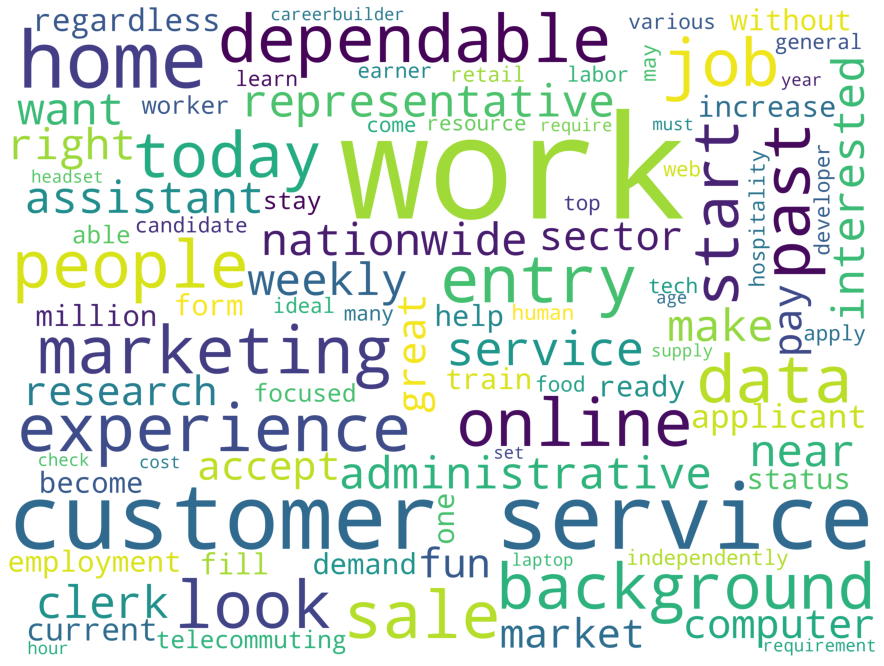

In [28]:
description_clean_text = ' '.join(description_clean)
fig = make_wordcloud(description_clean_text)

#### Process Full Dataset

In the cells below we process the full data set using the `data_processor` method.

##### `data_processor` method

In [29]:
display_object(DataProcessor.data_processor)

```python
def data_processor(docs):
    """data_processor. Takes a list of raw documents and executes full data
    processing pipeline for every document in the list.

    Parameters
    ----------
    docs : list of str
        List of strings containing the full text of your documents.
    """
    processed_data = [
        doc_processor(doc) for doc in docs
    ]
    return processed_data

```

##### Processing titles

In [30]:
titles = data['title']
titles_processed = DataProcessor.data_processor(tqdm(titles))

100%|██████████| 9666/9666 [00:11<00:00, 823.81it/s]


##### Processing descriptions

This cell takes several minutes to run.

In [31]:
descriptions = data['description']
descriptions_processed = DataProcessor.data_processor(tqdm(descriptions))

100%|██████████| 9666/9666 [09:47<00:00, 16.44it/s]


### Feature Engineering

#### Combining Common Phrases

Having cleaned our data we wish to combine common phrases into bigrams, trigrams, and quadgrams. This helps to ensure that each token in our final representation of our text is an independent unit of information.

The `data_combine_phrases` method uses the full corpus to detect common phrases and combine them into bigrams, trigrams, and quadgrams. when this method is run it saves a copy of the two required `Phrases` models to the `model` folder. This method depends on the following class.
 * `Phrases` from `gensim.models`
 
Once `data_combine_phrases` has built a phrase model for the provided data, we can combine phrases for an unseen document.

The `doc_combine_phrases` method will combine common phrases into $n$-grams for an unseen document. This method has the following dependencies.
 * `Phrases` from `gensim.models`
 * The model trained by `data_combine_phrases`

##### `data_combine_phrases` method

In [32]:
display_object(DataProcessor.data_combine_phrases)

```python
def data_combine_phrases(processed_data, prefix):
    """data_combine_phrases. Takes a corpus of cleaned documents and combines common phrases into
    bigrams, trigrams, and quadgrams.

    Parameters
    ----------
    processed_data : list of strings
        Takes output from data_processor.
    prefix : string
        prefix to identify saved model.
    """
    phrase_model_1 = Phrases(processed_data)
    phrase_model_1.save(f'../model/{prefix}-phrase_model_1.pkl')
    phrase_model_2 = Phrases(phrase_model_1[processed_data], min_count=1)
    phrase_model_2.save(f'../model/{prefix}-phrase_model_2.pkl')
    data_phrases = list(phrase_model_2[phrase_model_1[processed_data]])
    return data_phrases

```

##### Training on full dataset

In [33]:
title_phrases = DataProcessor.data_combine_phrases(tqdm(titles_processed), 'title')

100%|██████████| 9666/9666 [00:00<00:00, 30184.06it/s]


In [34]:
description_phrases = DataProcessor.data_combine_phrases(tqdm(descriptions_processed), 'description')

100%|██████████| 9666/9666 [00:08<00:00, 1165.38it/s]


##### `doc_combine_phrases` method

In [35]:
display_object(DataProcessor.doc_combine_phrases)

```python
def doc_combine_phrases(processed_doc, prefix):
    """doc_combine_phrases. Takes a processed document and combines common
    phrases into bigrams, trigrams, and quadgrams. data_combine_phrases must
    run before doc_combine_phrases.

    Parameters
    ----------
    processed_doc : list of strings
        Takes output from doc_processor.
    prefix : string
        prefix to identify saved model.
    """
    try:
        phrase_model_1 = Phrases.load(f'../model/{prefix}-phrase_model_1.pkl')
        phrase_model_2 = Phrases.load(f'../model/{prefix}-phrase_model_2.pkl')
    except:
        print('Call `data_combine_phrases` on processed data to build a phrase model')
        pass
    doc_phrases = list(phrase_model_2[phrase_model_2[processed_doc]])
    return doc_phrases

```

##### Example output

In [36]:
title_grams = DataProcessor.doc_combine_phrases(title_clean, 'title')
description_grams = DataProcessor.doc_combine_phrases(description_clean, 'description')
print(f'{title_grams}\n\n{description_grams}')

['customer_service_representative', 'data', 'entry', 'clerk']

['customer_service_representative', 'data', 'entry_clerk', 'customer', 'service', 'sale', 'customer', 'service', 'administrative_assistant_marketing', 'job_near', 'look_people_nationwide', 'interested', 'work_home_dependable', 'look', 'make', 'weekly', 'work', 'want', 'right', 'computer', 'online', 'work', 'market', 'research_sector_fun', 'pay', 'great_accept', 'applicant_regardless_past_current', 'experience', 'employment', 'status', 'without_past', 'experience_train_ready', 'become_one', 'million_people', 'work', 'form', 'home', 'help_fill_increase', 'demand_dependable_telecommuting_worker', 'able_stay_focused', 'work_independently', 'may', 'ideal_candidate_top_earner', 'come_various', 'background', 'customer', 'service', 'sale_marketing_human_resource', 'retail_hospitality_food', 'service_general_labor', 'tech_web', 'developer_many', 'apply_online_learn', 'get_start', 'today_job', 'requirement', 'must', 'year', 'age_back

##### Description grams word cloud

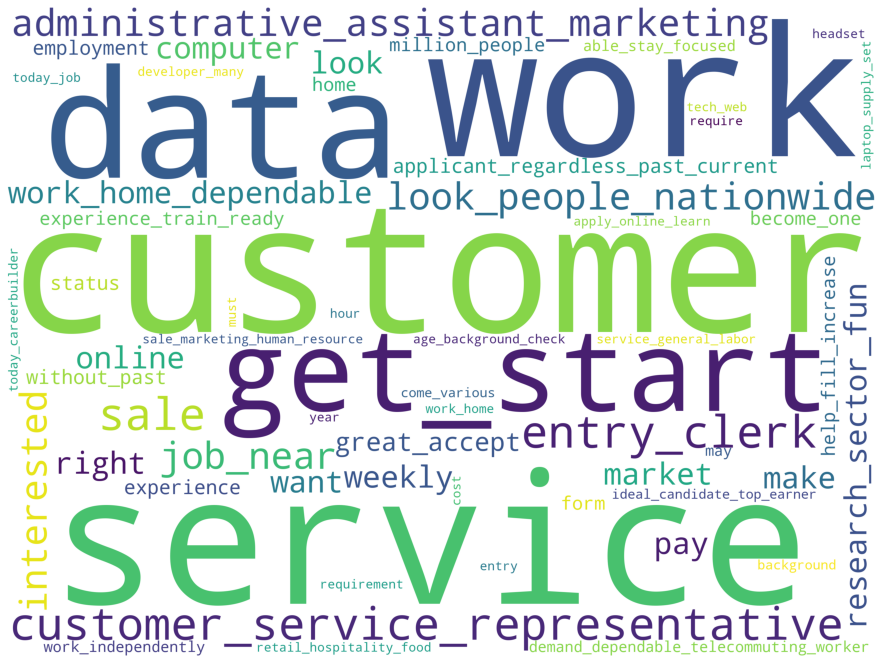

In [37]:
description_grams_text = ' '.join(description_grams)
fig = make_wordcloud(description_grams_text)

### Processed Data Storage

As we saw above. It takes around ten minutes in total to execute data cleaning and feature engineering on the full data set. For this reason it is useful to store our processed data for future use. Below we package our raw data with our processed data in a list of dictionaries and save the resulting object as a pickle file.

#### Combining raw data and processed data for storage

In [38]:
data_records = data.to_dict('records')
for post, description_tokens, title_tokens in tqdm(zip(data_records, description_phrases, title_phrases)):
    post['title_tokens'] = title_tokens
    post['description_tokens'] = description_tokens

9666it [00:00, 1000768.74it/s]


#### Inspecting the first record

In [39]:
data_records[1]

{'title': 'QA Engineer',
 'url': 'https://www.careerjet.com/jobad/usd99666605afa1b6c5df56a4819c7a373',
 'description': "\\n  \\n    We’d love to hear from you if you are looking for:  Start-up energy working with a brilliant and passionate team $300 billion market opportunity Exponential growth (6 straight quarters of 50-100%+ quarter over quarter growth) Open communication environment based on high integrity values Rockstar teammates. You will be working with a strong team with prior work experience at Amazon, Microsoft, Alibaba, Nivida, etc.   About jerry.ai:  Jerry.ai is building the first financial platform for your car that helps people optimize the cost and experience of owning a car (making ownership easy & affordable). There are 240M cars in the US alone. For most people, cars are one of the most expensive assets they own and families on average spend 20% of their income on car expenses, making this a massive market.  We have started with helping people optimize the cost of car

#### Saving to pickle file

The line below should only be run if the `processed_data` file needs to be updated.

```python
with open('../data/processed_data.pkl', mode='wb') as file:
    pickle.dump(data_records, file)
```

## Modeling

The purpose of a job posting is to communicate the responsibilities and requirements of a job to potential applicants. When a job seeker is viewing job postings, their goal is to identify jobs that are closely aligned with their skills efficiently. Both employers and job seekers benefit from postings that efficiently communicate the precise requirements of a job. The employer receives more relevant job applicants, which results in a more efficient hiring process. The job seeker is able to evaluate jobs effectively and invest time in applying to only those jobs that are relevant to their skills, which results in a more efficient job seeking process.

The first step of the job seeking process is to evaluate large batches of job postings and identify relevant postings. In this phase, the greatest contributer to efficiency is the ability to rapidly reject irrelevant postings. The most consistently available information in a job posting is a job title and a job description. A fairly standard approach to reviewing a collection of job postings is to read the job titles, reject all of the postings with irrelevant job titles and then review the job descriptions for the remaining job posts. Because reviewing a job description can take substantially longer than reviewing a job title, it is not feasible to review all job descriptions. 

An issue arises with this strategy if job titles do not provide an accurate classification of the job that they describe. The primary issue being low accuracy in predicting the nature of a job from the job title. In the case of a false negative, the job seeker incorrectly classifies a job as irrelevant and discards it without further review, missing an opportunity to apply for a relevant job. In the case of a false positive, the job seeker carries an irrelevant job posting forward for further review, incurring an opportunity cost by wasting time that could have been used pursuing a relevant job.

In this section, we take the view that a job description is a complete and correct representation of the job. Our first modeling task is to produce quantitative representation of the data contained in the job description. For this task, we have selected a Latent Dirichlet Allocation (LDA) model. This type of model assumes that every document (job description) in our corpus is created by selecting a mixture of topics (responsibilities and requirements) and then selecting words according to a distribution that is conditioned on the mixture of topics. This is a plausible model for job descriptions since the author of the job posting must describe a handful of requirements of the job, where each requirement will have a handful of distinguishing key words. 

A fitted LDA model produces a list of topics, each containing a list of top keywords. For any document, the model provides a probability vector indicating the mixture of topics that are present in the document. 

Because the list of topics are inferred from the corpus of documents, we must review the list of top keywords and identify the essential meaning of the topic. 

One of the hyper parameters of an LDA model is the number of topics to detect. It is important that we carefully select an appropriate number of topics. We want our topics to be coherent, which generally drives us toward more topics which capture smaller and more precise topics. On the other hand, we want our topic to be distinct, this generally drives us toward fewer topics. By balancing these two considerations, we will select an appropriate number of topics for our LDA model. 

Once we have a topic mixture representation of our job descriptions, we can cluster jobs into classes with similar mixtures of topics. For this task we will use a $k$-means clustering algorithm.

We will need to tune the number of clusters for our $k$-means clustering to ensure that jobs are grouped into distinct and self similar classes. 

Finally, we will train a multinomial Naive Bayes' classifier on the job titles to predict the job class produced by LDA and $k$-means. The accuracy of this model provides an estimate of the accuracy of classifying jobs as relevant or not based on job title alone. 

### Architecture

### Testing Plan

Both LDA and $k$-means are unsupervised learning techniques, as such we will need to carefully tune hyper-parameters to ensure that these models are performing optimally. However, we do not have access to ground truth to test these models.

For our Multinomial Naive Bayes' classifier, we will implement a train test split for model verification and use five-fold cross-validation to validate our selection of the number of clusters.

### Build

#### Load Processed Data

In [40]:
with open('../data/processed_data.pkl', mode='rb') as file:
    data_records = pickle.load(file)

title_tokens = [record['title_tokens'] for record in data_records]
description_tokens = [record['description_tokens'] for record in data_records]

#### Latent Dirichlet Allocation Topic Model

##### Build dictionary and corpus

In [41]:
dictionary = corpora.Dictionary(tqdm(description_tokens))
dictionary.filter_extremes(no_below=3)

100%|██████████| 9666/9666 [00:04<00:00, 2079.64it/s]


In [42]:
corpus = [dictionary.doc2bow(token) for token in tqdm(description_tokens)]

100%|██████████| 9666/9666 [00:02<00:00, 3795.02it/s]


##### Build LDA models

In [43]:
response = input('This cell takes a long time to run. Would you like to skip it? (y/n)')
if response.lower() == 'y':
    pass
elif response.lower() =='n':
    np.random.seed(42)
    eta = [0.01]*len(dictionary.keys())
    for num_topics in tqdm(range(2,31)):
        alpha = [0.01]*num_topics
        lda_model = LdaModel(
            corpus, 
            num_topics=num_topics,
            id2word=dictionary,
            passes=4, 
            alpha=alpha,
            eta=eta
        )
        file_path = f'../model/LDA-{num_topics}topics'
        lda_model.save(file_path)
else:
    print('Could not interpret response. Run cell again.')

This cell takes a long time to run. Would you like to skip it? (y/n)y


##### Tuning the number of topics for LDA

A Latent Dirichlet Allocation model tries to learn a fixed number of latent topics from a corpus of texts. In order to produce the best possible representation of our Job descriptions it is important to select an appropriate number of topics. 

We will use two measures of model quality to select the number of topics for our final model. First, mean Jaccard similarity of topics, which essentially measures how much overlap there is between topics. A lower value of this measure indicates a better model. Second, coherence of topics, which essentially measures how internally consistent the top words are from each topic. A higher value of this measure indicates a better model.

Both measures return values in the range from zero to one and we will select the number of topics which produces the largest difference of coherence minus Jaccard similarity, preferring fewer topics in the case of a near tie.

##### Computing measures

To compute both measures for each saved LDA model, we call the `get_measures` method from the `topic_selection` module. This method takes substantial time to run.

In [44]:
import topic_selection
display_object(topic_selection.get_measures)

```python
def get_measures(texts, dictionary):
    """get_measures. Collects Jaccard similarity and coherence for all trained
    LDA models.

    Parameters
    ----------
    model:
        A trained LDA model. Takes input from get_model.
    texts :
        texts
    dictionary :
        dictionary
    """
    measures_list = {
        'n': [],
        'mean_jaccard': [],
        'coherence': []        
    }
    for n in tqdm(range(2,31)):
        model = get_model(n)
        topics = get_topics(model)
        measures_list['n'].append(n)
        measures_list['mean_jaccard'].append(mean_jaccard_similarity(topics)),
        measures_list['coherence'].append(get_coherence(model, texts, dictionary))
    return measures_list

```

In [45]:
response = input('This cell takes a long time to run. Would you like to skip it? (y/n)')
if response.lower() == 'y':
    pass
elif response.lower() =='n':
    measures_list = topic_selection.get_measures(description_tokens, dictionary)
    with open('../model/measures.pkl', mode='wb') as file:
        pickle.dump(measures_list, file)
else:
    print('Could not interpret response. Run cell again.')

This cell takes a long time to run. Would you like to skip it? (y/n)y


In [46]:
with open('../model/measures.pkl', mode='rb') as file:
    measures = pickle.load(file)
    
measures_df = pd.DataFrame(measures)
measures_df['diff'] = measures_df['coherence'] - measures_df['mean_jaccard']
px.line(
    data_frame = measures_df,
    x = 'n',
    y = ['mean_jaccard', 'coherence', 'diff'],
    title = 'latent dirichlet allocation topic number selection'.title(),
    labels = {
        'n': 'Number of Topics',
        'variable': 'Metric'
    }
)

##### Selection of number of topics

Based on our selection criterion and the plot above we select ten topics for our model.

In [47]:
num_topics = 10
lda_model = topic_selection.get_model(num_topics)

##### Future work

It might be advisable to investigate models with a number of topics greater than 28 in the future.

#### $k$-Means Clustering of Jobs

##### Computing topic distributions

In the cell below, we use our LDA model to compute topic distributions for our corpus of job descriptions. Each job description is represented as a 28 dimensional probability vector, which describes the mixture of topics present in the description.

In [48]:
def get_topic_distributions(lda_model, corpus):
    rows = []
    for description in tqdm(corpus):
        topics = lda_model.get_document_topics(description)
        vec = np.zeros(num_topics)
        for key, prob in topics:
            vec[key] = prob
        rows.append(vec)
    topic_distributions = np.array(rows)
    return topic_distributions

topic_distributions = get_topic_distributions(lda_model, corpus)

100%|██████████| 9666/9666 [00:14<00:00, 659.90it/s]


##### Tuning the number of clusters

For our $k$-means clustering model we need to select an appropriate number of clusters. To this end we will compute three well regarded measures of clustering quality: Calinski Harabasz Score, Within Cluster Sum of Squares, and Silhouette Score. We will select a number of clusters where one or more of these measures exhibits a marked change in trend, we will prefer fewer clusters if there are multiple candidates.

##### Computing measures

In [49]:
def get_measures(topic_distributions):
    measures = {
        'n_clusters': [],
        'CH_score': [],
        'WCSS_score': [],
        'S_score': []
    }

    for n_clusters in tqdm(range(2, 40)):
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        preds = clusterer.fit_predict(topic_distributions)
        measures['CH_score'].append(calinski_harabasz_score(topic_distributions, preds))
        measures['WCSS_score'].append(clusterer.inertia_)
        measures['S_score'].append(silhouette_score(topic_distributions,preds))
        measures['n_clusters'].append(n_clusters)
    return measures

measures = get_measures(topic_distributions)

100%|██████████| 38/38 [02:38<00:00,  4.17s/it]


In [71]:
km_measures_df = pd.DataFrame(measures)
fig = px.line(
    data_frame = km_measures_df,
    width=800,
    height=600,
    x='n_clusters', 
    y=['CH_score'], 
    title='Calinski Harabasz',

)
fig.show()

In [72]:
fig = px.line(
    data_frame = km_measures_df,
    x='n_clusters', 
    y=['WCSS_score'], 
    width=800,
    height=600,
    title='Within Cluster Sum of Squares',

)
fig.show()

In [73]:
fig = px.line(
    data_frame = km_measures_df,
    x='n_clusters', 
    y='S_score',
    width=800,
    height=600,
    title='Silhouette Score',
    labels ={
        'n_clusters': 'Number of Clusters',
        'S_score': 'Silhouette Score'
    }
)    
fig.show()

##### Selecting the number of clusters

The most marked change in trend is in the Silhouette Score at ten clusters, so we select this value for our number of clusters.

In [53]:
num_clusters = 10
km_model = KMeans(num_clusters)

#### Multinomial Naive Bayes Classification of Jobs

##### Convert title tokens to word count vectors

In [54]:
vectorizer = CountVectorizer()
titles = [' '.join(title_list) for title_list in title_tokens]
X = vectorizer.fit_transform(titles)
X.shape

(9666, 2566)

##### Assign job classes using $k$-means model

In [55]:
y = km_model.fit_predict(topic_distributions)

##### Perform train test split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### Define gridsearch over $\alpha$

The parameter $\alpha$ is a smoothing parameter, by default the Multinomial Naive Bayes' classifier uses Laplace smoothing, which corresponds to $\alpha = 1$ we also test Lidstone smoothing with $\alpha = 10^{-5}, 0.01, 0.1$. 

In [57]:
clf = MultinomialNB()
param_grid = {'alpha' : [1e-5, 1e-2, 1e-1, 1]}
grid = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=2)

In [58]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.5s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 0.1, 1]}, scoring='accuracy',
             verbose=2)

In [80]:
grid_df = pd.DataFrame(grid.cv_results_)
px.line(
    data_frame = grid_df,
    x = 'param_alpha',
    y = 'mean_test_score',
    title='Five-Fold Crossvalidation for alpha',
    labels={
        'param_alpha': 'alpha',
        'mean_test_score': 'Mean Accuracy'
    },
    width=800,
    height=600
)

##### Selecting best Multinomial Naive Bayes' model

As we saw above the best value of $\alpha$ was $0.1$.

In [60]:
mnb_model = grid.best_estimator_

### Assessment

Having built our models. We wish to asses our models.

#### Inspecting LDA Topics

See the [reference paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) for more information about the tool below. The authors recommend $\lambda =0.6$ for clasifying topics.

In [62]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the
# N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 
# (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(
    topic_model=lda_model, 
    corpus=corpus, 
    dictionary=dictionary
)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

##### Declaring Topic Labels

In the cell below we declare labels for the LDA topics. These are subjective labels based on inspecting the topics using the tool above.

In [63]:
topic_labels = {
    0: 'Business Analysis',
    1: 'Process Management',
    2: 'System Administration',
    3: 'Data Science',
    4: 'Big Data',
    5: 'Technical Leadership',
    6: 'Compliance',
    7: 'Company Culture', 
    8: 'Part Time',
    9: 'Nonsense'
}

#### Inspecting Job Clusters

In [64]:
cluster_centers = km_model.cluster_centers_
cluster_frame = pd.DataFrame(cluster_centers, columns=topic_labels.values())
fig = px.bar(
    data_frame = cluster_frame,
    title = 'Distribution of JobTopics by JobClass',
    height= 600,
    width=800,
    labels = {
        'variable': 'JobTopic',
        'index': 'JobClass',
        'value': 'Percent Relevence'
    }
)
fig.show()

#### Estimated Accuracy of Classifying Jobs by Title

Below we see that our best estimate for the accuracy of classifying data industry job postings by job title is 55%. So we would expect that a job seeker will incorrectly classify a job posting about half of the time when skimming job titles.

In [68]:
pred_test = mnb_model.predict(X_test)
score_test = mnb_model.score(X_test, y_test)
fig = px.imshow(
    confusion_matrix(y_test, pred_test, normalize='true'),
    title = f'Predicting JobClass from Job Title (Accuracy {round(score_test,2)})',
    color_continuous_scale='Blues',
    height = 600,
    width = 600,
    labels = {
        'x': 'Predicted',
        'y': 'Observed',
        'color': 'Proportion of Observed'
    }
)
fig.show()

## Evaluation

### Results

We found that data industry job descriptions are well represented by a ten topic model and that we are able to cluster job postings into ten distinct classes based on these topics. 

We also found that we were only able to correctly predict the job class from the job title correctly about half the time. This indicates that job titles are not well aligned with job requirements in the data industry. 

Our model is able to provide a topic distribution and job classification for an unseen job posting. The topic distribution and classification could be used as an alternative to job titles as a means for quick job evaluation. 

### Review 

At the moment the modeling pipeline is implemented and has provided interesting insights.

Before moving to deployment, it would be wise to spend some time cleaning up the code base for this project since some of the central analysis is currently happening in this notebook and would be hard to deploy

### Conclusion

Our first model used unsupervised learning to detect ten key topics that regularly occur within data industry job postings. We selected the number of topics in section [Tuning the number of topics for LDA](#Tuning-the-number-of-topics-for-LDA). We found that the difference between topic coherence and topic similarity improved fairly quickly up to ten topics, after which improvement was slower and more erratic.

From our ten topics we identified seven key skill sets namely:
 * Big Data
 * Business Analysis
 * Compliance
 * Data Science
 * Process Management
 * System Administration
 * Technical Leadership
 
We also identified three other topics: 
 * Company Culture
 * Part Time
 * Nonsense

Labeling these topics was a subjective process that was aided by the graphical tool in the section [Inspecting-LDA-Topics](#Inspecting-LDA-Topics). The tool is discussed in depth in this [reference paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) where the authors recommend the value $\lambda =0.6$ for effective labeling of topics.

For any data industry job description, this first model can provide a ten number summary, which we call JobTopics, indicating the mixture of topics present. We recommend that JobTopics should be used to supplement job postings providing an at-a-glance summary of the job that is more information rich than the job title.

Our second model seeks to classify jobs based on the topic representation produced by our first model. Since the topic representation of a job description is a ten dimensional probability vector, we can use an unsupervised clustering technique to group similar jobs together. We used $k$-means clustering with ten clusters. Our selection of ten clusters was based primarily on Calinski Harabasz and Silhouette scores, see section [$k$-Means Clustering of Jobs](#K-Means-Clustering-of-Jobs).

We observe that 
 * Cluster 1 seems to capture part-time work.
 * Cluster 5 captures postings with an abundance of boilerplate language. 
 * Clusters 4 and 7 capture highly specialized roles.
 * Clusters 0, 2, 3, 6, 8, and 9 capture roles that require a mixture of skills.
 
 For any data industry job description, our second model can provide a data supported JobClass. This classification serves to even more succinctly summarize a job description and shows that there are eight distinct full-time positions that are commonly observed. We recommend that JobClass be used by employers to guide assignment of job titles to job descriptions and by job forums to filter job postings. 
 
Our third model uses a supervised classification algorithm to simulate the experience of a job seeker who is vetting a large list of job postings for further review based solely on the existing job title. We tune and validate this model in section [Multinomial Naive Bayes Classification of Jobs](#Multinomial-Naive-Bayes-Classification-of-Jobs).

Using our third model we found that, by using the job title to predict the JobClass for a job posting, we were only able to correctly assign JobClass with 55% accuracy. While 55% accuracy is much better than random guessing for a ten class problem, we observe that two undesirable outcomes are still quite likely for a job seeker.
 1. The job seeker incorrectly rejects a job posting for further review based on the job title, thereby completely missing an opportunity.
 2. The job seeker incorrectly accepts a job posting for further review based on the job title, thereby incurring an opportunity cost by spending additional time reviewing an inappropriate job posting. 

Our third model confirms a widely held belief that job titles do not faithfully represent job descriptions in the data industry. Our first and second models provide high quality data driven products, namely JobTopics and JobClass, which can help to improve efficiency in the data job market by providing relevant at-a-glance summaries of job descriptions.

## Deployment

### Deployment Plan

Our goal is to deploy a website that will display the top twenty search results from careerjet.com with topic distributions and job classifications.

### Monitoring and Maintenance

Ideally there should be a regular data scraping and retraining cycle applied at regular intervals. The model should be assessed for stability as data is updated.